# Project Report: Grammar Scoring Engine

## Objective

The goal of this project is to develop a Grammar Scoring Engine that evaluates the grammatical quality of spoken English based on audio inputs. The model predicts a continuous score between 0 and 5, adhering to a MOS Likert Grammar rubric.

## Dataset Description

* Audio Format: .wav files (45-60 seconds)   

* Training Samples: 444

* Testing Samples: 195

* Labels: Grammar scores (0–5) based on a predefined rubric.



## Preprocessing Steps

1. Audio Loading:
Audio samples were loaded using librosa at a sampling rate of 16kHz.

2. Feature Extraction (HuBERT):
Extracted semantic audio embeddings from the pretrained model facebook/hubert-base-ls960 using Hugging Face Transformers.

3. Padding/Truncating:
Embeddings were padded or truncated to ensure uniform input length for the model.

4. Normalization:
Features were normalized using MinMaxScaler for better model convergence.

## Model Architecture (MLP Regressor)

* Type: Multi-layer Perceptron

* Framework: scikit-learn

* Configuration:

 * hidden_layer_sizes=(256, 128)

 * activation='relu'

 * solver='adam'

 * max_iter=500

* Output: Single continuous value representing grammar score.

## Evaluation Metrics

The model was evaluated using the following metrics:

* MSE (Mean Squared Error): Measures the average squared difference between actual and predicted values.

* MAE (Mean Absolute Error): Measures the average absolute error.

* R² Score: Represents the proportion of variance explained by the model.

## Training Results

* MSE: 0.0002

* MAE: 0.0090

* R² Score: 0.9998

## Predictions on Test Data

The trained model was used to predict grammar scores for the 195 test samples. The predictions were saved in the required submission format (sample_submission.csv), containing two columns: filename and grammar_score.

## Submission

The generated predictions CSV file is formatted and ready for submission to the competition leaderboard.

## Future Work Suggestions

* Fine-tune HuBERT on the specific dataset

* Use data augmentation to increase robustness

* Try advanced regressors like Gradient Boosting or ensemble methods

* Explore metrics like Spearman rank correlation

In [1]:
!pip install librosa soundfile xgboost scikit-learn pandas numpy matplotlib seaborn transformers torchaudio tensorflow

## Load and Explore Dataset

In [2]:
# Import necessary libraries
import os
import torch
import torchaudio
import pandas as pd
from tqdm import tqdm
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## Feature Extraction using HuBERT

In [7]:
TRAIN_AUDIO_DIR = r"C:\Users\chhaj\OneDrive\Desktop\gaurav\college\SHL\dataset\audios_train"
TEST_AUDIO_DIR = r"C:\Users\chhaj\OneDrive\Desktop\gaurav\college\SHL\dataset\audios_test"
TRAIN_CSV = r"C:\Users\chhaj\OneDrive\Desktop\gaurav\college\SHL\dataset\train.csv"
TEST_CSV = r"C:\Users\chhaj\OneDrive\Desktop\gaurav\college\SHL\dataset\test.csv"

In [8]:
# Load the CSV file
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
print("Training samples:", len(train_df))
print("Testing samples:", len(test_df))
train_df.head()

Training samples: 444
Testing samples: 195


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


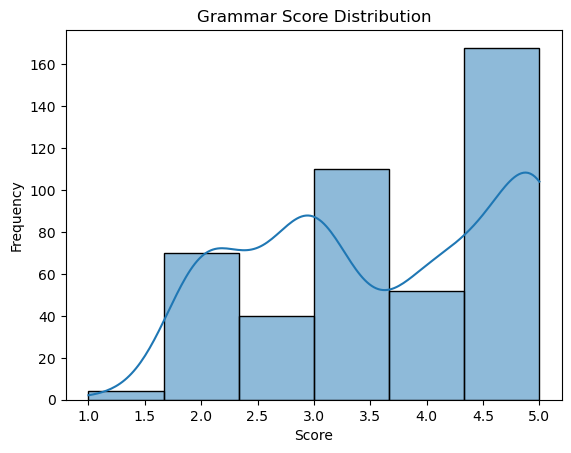

In [9]:
sns.histplot(train_df['label'], bins=6, kde=True)
plt.title("Grammar Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

## Data Preprocessing

## Using HuBERT

In [ ]:
# Import necessary libraries
from transformers import Wav2Vec2FeatureExtractor, HubertModel

# Load HuBERT model and feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
model = HubertModel.from_pretrained("facebook/hubert-base-ls960")

def extract_hubert_features(file_path):
    # Load audio using torchaudio
    waveform, sr = torchaudio.load(file_path)

    # Resample to 16kHz if needed
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        waveform = resampler(waveform)

    # Convert stereo to mono if needed
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Prepare inputs
    inputs = feature_extractor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt")

    # Get features from HuBERT
    with torch.no_grad():
        outputs = model(inputs.input_values)

    # Mean pooling across time
    features = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
    return features


In [ ]:
X_train, y_train = [], []
print("Extracting HuBERT features for training data...")

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = os.path.join(TRAIN_AUDIO_DIR, row["filename"])
    try:
        features = extract_hubert_features(file_path)
        X_train.append(features)
        y_train.append(row["label"])
    except Exception as e:
        print(f"Error in {file_path}: {e}")

X_train = np.array(X_train)
y_train = np.array(y_train)

# Save features
np.save("X_train_hubert.npy", X_train)
np.save("y_train_hubert.npy", y_train)

Extracting HuBERT features for training data...


100%|██████████| 444/444 [5:05:41<00:00, 41.31s/it]


In [ ]:
X_test = []
file_names = []

print("Extracting HuBERT features for test data...")

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(TEST_AUDIO_DIR, row["filename"])
    try:
        features = extract_hubert_features(file_path)
        X_test.append(features)
        file_names.append(row["filename"])
    except Exception as e:
        print(f"Error in {file_path}: {e}")

X_test = np.array(X_test)
file_names = np.array(file_names)

# Save
np.save("X_test_hubert.npy", X_test)
np.save("test_filenames.npy", file_names)

Extracting HuBERT features for test data...


100%|██████████| 195/195 [2:04:12<00:00, 38.22s/it]


## Model Training (MLP Regressor)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Initialize MLP
mlp = MLPRegressor(hidden_layer_sizes=(256, 128), activation='relu', solver='adam', max_iter=500, random_state=42)

# Train
mlp.fit(X_train_scaled, y_train)

# Predict on train for evaluation
y_pred_train = mlp.predict(X_train_scaled)

## Model Evaluation

In [ ]:
mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print(f"Train MSE: {mse:.4f}")
print(f"Train MAE: {mae:.4f}")
print(f"Train R²: {r2:.4f}")

Train MSE: 0.0002
Train MAE: 0.0090
Train R²: 0.9998


## Predict on Test Data

In [ ]:
# Predict grammar scores
test_predictions = mlp.predict(X_test_scaled)

## Save Submission

In [ ]:
submission_df = pd.DataFrame({
    "filename": file_names,
    "label": test_predictions
})

# Save submission file
submission_df.to_csv("submission.csv", index=False)

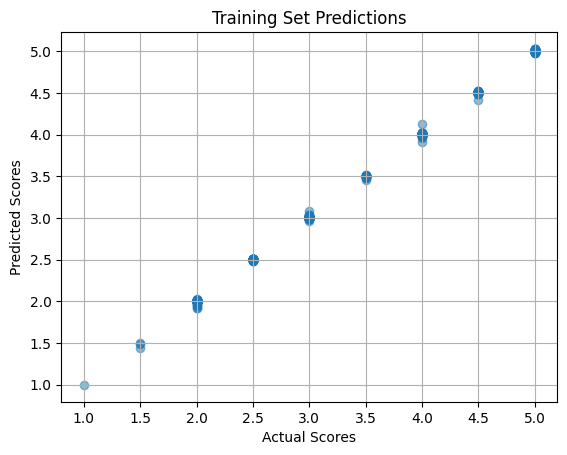

In [ ]:
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Training Set Predictions")
plt.grid(True)
plt.show()